In [38]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import datetime
import gc
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier

%matplotlib inline

In [2]:
# read in all the data
train_identity = pd.read_csv('data/train_identity.csv')
train_transaction = pd.read_csv('data/train_transaction.csv')
test_identity = pd.read_csv('data/test_identity.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')

In [3]:
# check out the shape of the data
print(train_identity.shape, test_identity.shape)
print(train_transaction.shape, test_transaction.shape)

(144233, 41) (141907, 41)
(590540, 394) (506691, 393)


In [4]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# There are a lot of NaNs, missing data, and it seems really imbalanced... We need to find what % is fraud first I suppose
# we can't use all the data because not all of it is fraud related, or else we would overfit

In [6]:
# checking % of missing data
missing_count = train_transaction.isnull().sum()
print(missing_count[0:10])
total_count = np.product(train_transaction.shape)
total_missing = missing_count.sum()
print('% of missing data', (total_missing/total_count) * 100)

TransactionID        0
isFraud              0
TransactionDT        0
TransactionAmt       0
ProductCD            0
card1                0
card2             8933
card3             1565
card4             1577
card5             4259
dtype: int64
% of missing data 41.073431200111266


In [7]:
# checking % of missing data
missing_count = train_identity.isnull().sum()
print(missing_count[0:10])
total_count = np.product(train_identity.shape)
total_missing = missing_count.sum()
print('% of missing data', (total_missing/total_count) * 100)

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
dtype: int64
% of missing data 35.58109650830896


In [8]:
# We have to make sure that the transctions are in the  train_identity CSV
check1 = np.sum(train_transaction['TransactionID'].isin(train_identity['TransactionID'].unique()))
check2 = np.sum(test_transaction['TransactionID'].isin(test_identity['TransactionID'].unique()))
print((check1/590540)*100)
print((check2/590540)*100)

24.42391709283029
24.030040302096385


In [ ]:
# join identity and transaction on TransactionID

# train = pd.merge(train_identity, train_transaction, on='TransactionID', how='left')
# test = pd.merge(test_identity, test_transaction, on='TransactionID', how='left')

## Function to reduce memory usage

In [9]:
# reduce memory usage because of large size and long compute time 
# also i think we should delete objects after using them so they aren't stored in memory, del train_identity (for example)
# we could potentially use this package to reduce memory usage? if not we can write our own script 
 
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > df[col].astype(np.int64) and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        #else:
                        #df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df 


In [10]:
# function must be run everytime you restart the notebook?
train_identity = reduce_mem_usage(train_identity)
train_transaction = reduce_mem_usage(train_transaction)
test_identity = reduce_mem_usage(test_identity)
test_transaction = reduce_mem_usage(test_transaction)

Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 25.86 MB
Decreased by 42.7%
Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 542.35 MB
Decreased by 69.4%
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 25.44 MB
Decreased by 42.7%
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 472.59 MB
Decreased by 68.9%


In [ ]:
# try the class weight method, also try to understand how imbalanced the dataset is more

## Visualizing the imbalance between train and test 

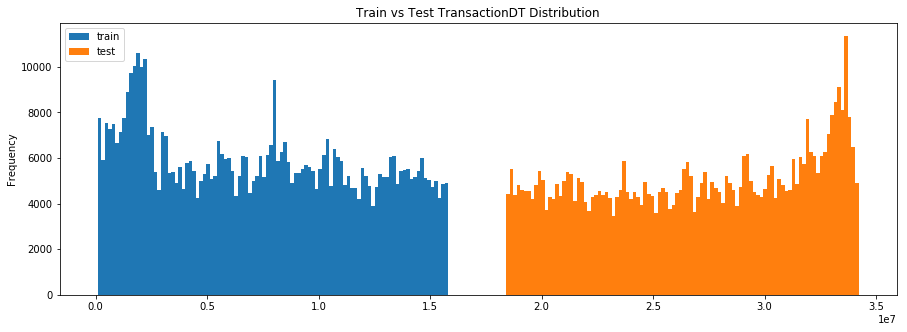

In [11]:
# TransactionDT is not the actual datetime of the transaction, it is the time delta between transactions
# as shown with the visualization below, there is a gap between train and test, train was recorded earlier than test 
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=100,
                                        title='Train vs Test TransactionDT Distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=100)
plt.legend()
plt.show()

## Fraud target variable count

Text(0.5, 1.0, 'Target variable count')

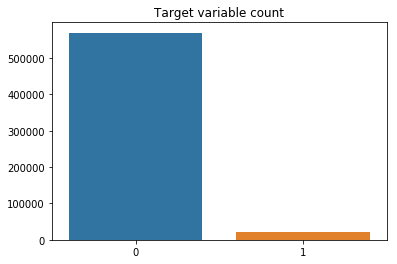

In [12]:
x=train_transaction['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

In [13]:
# type of card based on card4 column: discover, mastercard, visa, etc. 
card_type = train_transaction['card4']
card_type.head(5)

0      discover
1    mastercard
2          visa
3    mastercard
4    mastercard
Name: card4, dtype: object

In [ ]:
# first attempt to partition the credit cards based on type

# x = train_transaction['card4'].value_counts().values
# sns.barplot([0,1],x)
# plt.title('Card Count')

In [14]:
# product code and product for each transaction, denotes any type of product or service, not just physical goods
product_code = train_transaction['ProductCD']
product_code.head()

0    W
1    W
2    W
3    W
4    H
Name: ProductCD, dtype: object

Text(0.5, 1.0, 'Product Code Count')

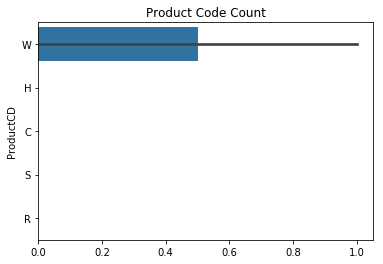

In [15]:
# first attempt at visualizing this

y = train_transaction['ProductCD']
sns.barplot([0,1],y)
plt.title('Product Code Count')

## All categorical variables 

In [16]:
# all categorical variables
categorical_variables = ('ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
                        'Pemaildomain', 'Remaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9')
print(categorical_variables)

('ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'Pemaildomain', 'Remaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9')


## Fraud visual with percentages

,0,1
isFraud,96.500999,3.499001


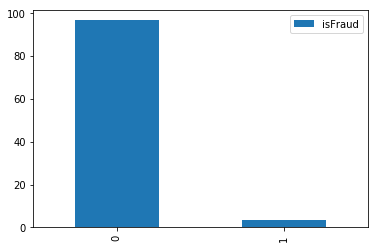

In [17]:
# more isFraud visualization
fraud_count = train_transaction['isFraud'].value_counts(normalize=True).to_frame()
fraud_count *= 100
fraud_count.plot.bar()
fraud_count.T
# print(fraud_count.T, '%')

## Fraud transaction rates by day, and week

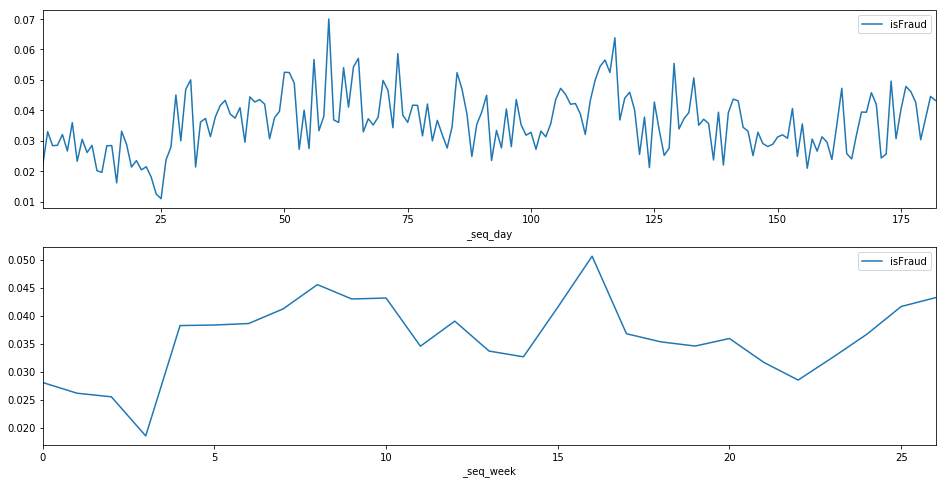

In [18]:
# fraud transaction rates by day and then by week
fig, ax = plt.subplots(2, 1, figsize=(16, 8))

train_transaction['_seq_day'] = train_transaction['TransactionDT'] // (24*60*60)
train_transaction['_seq_week'] = train_transaction['_seq_day'] // 7
train_transaction.groupby('_seq_day')['isFraud'].mean().to_frame().plot.line(ax=ax[0])
train_transaction.groupby('_seq_week')['isFraud'].mean().to_frame().plot.line(ax=ax[1])

## Fraud transactions by weekday, hour of the day, day of the week, and month of the year

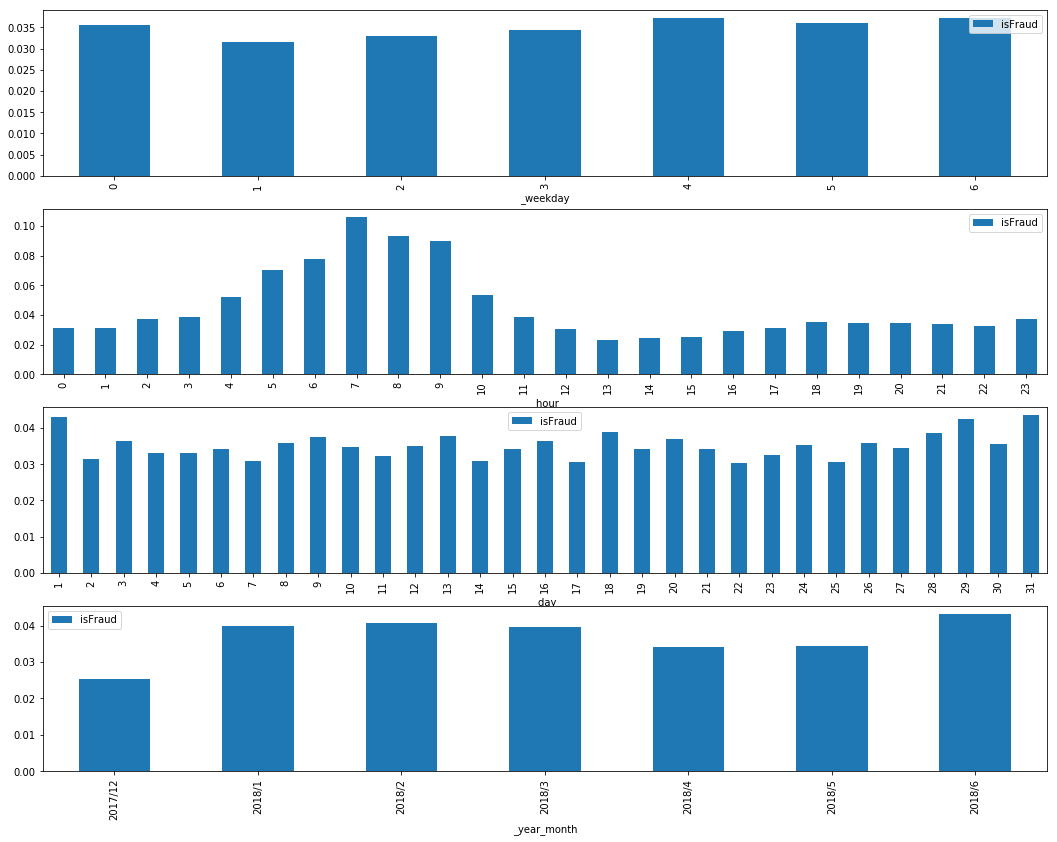

In [19]:
start_date = '2017-12-01'
startdate = datetime.datetime.strptime(start_date, '%Y-%m-%d')
train_transaction['Date'] = train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train_transaction['_year_month'] = train_transaction['Date'].dt.year.astype(str) + '/' + train_transaction['Date'].dt.month.astype(str)
train_transaction['_weekday'] = train_transaction['Date'].dt.dayofweek
train_transaction['_hour'] = train_transaction['Date'].dt.hour
train_transaction['_day'] = train_transaction['Date'].dt.day

fig,ax = plt.subplots(4, 1, figsize=(18, 14))

train_transaction.groupby('_weekday')['isFraud'].mean().to_frame().plot.bar(ax=ax[0])
train_transaction.groupby('_hour')['isFraud'].mean().to_frame().plot.bar(ax=ax[1])
train_transaction.groupby('_day')['isFraud'].mean().to_frame().plot.bar(ax=ax[2])
train_transaction.groupby('_year_month')['isFraud'].mean().to_frame().plot.bar(ax=ax[3])

## Fraud transaction rates by weekday hour

In [ ]:
train_transaction['_weekday_hour'] = train_transaction['_weekday'].astype(str)+ '_' + train_transaction['_hour'].astype(str)
train_transaction.groupby('_weekday_hour')['isFraud'].mean().to_frame().plot.line(figsize=(16,3))

In [22]:
# merge train identity and train transaction on isFraudn and TransactionID
train_identity_transaction = pd.merge(train_identity, train_transaction[['isFraud', 'TransactionID']])
train_identity_0 = train_identity_transaction[train_identity_transaction['isFraud'] == 0]
train_identity_1 = train_identity_transaction[train_identity_transaction['isFraud'] == 1]
print(train_identity_0.shape, train_identity_1.shape)

(132915, 42) (11318, 42)


## Histograms of ID

In [25]:
# function to plot histograms of different id numbers
def PlotFraudHist(col, bins=20, figsize=(8,3)):
    with np.errstate(invalid='ignore'):
        plt.figure(figsize=figsize)
        plt.hist([train_identity_0[col], train_identity_1[col]], bins=bins, density=True, color=['blue', 'red'])

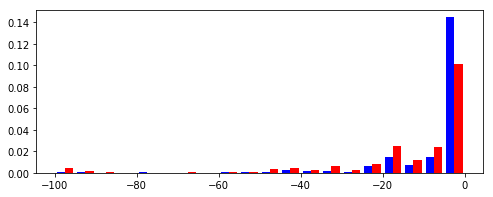

In [26]:
PlotFraudHist('id_01')

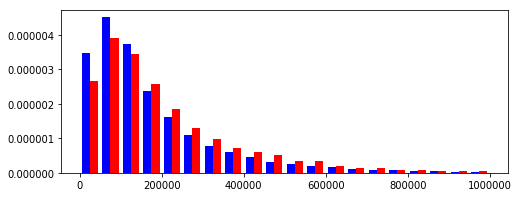

In [24]:
PlotFraudHist('id_02')

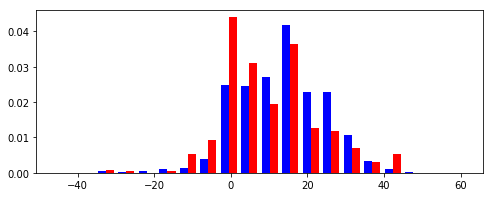

In [25]:
PlotFraudHist('id_07')

## Bar plots of ID

In [7]:
# function to make bar plots of fraud id numbers 
def plotFraudBar(col, topN=np.nan, figsize=(8,3)):
    x, y = train_identity_0, train_identity_1
    if topN == topN:
        vals = y[col].value_counts(normalize=True).to_frame().iloc[:topN, 0]
        sub_x = x.loc[x[col].isin(vals.index.values), col]
        df = pd.DataFrame({'normal':x[col].value_counts(normalize=True), 'fraud':vals})
    else:
        df = pd.DataFrame({'normal':x[col].value_counts(normalize=True), 'fraud':y[col].value_counts(normalize=True)})
    df.sort_values('fraud', ascending=False).plot.bar(figsize=figsize)
            

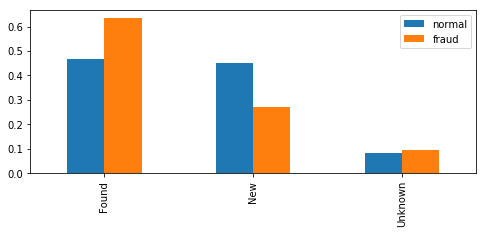

In [27]:
plotFraudBar('id_15')

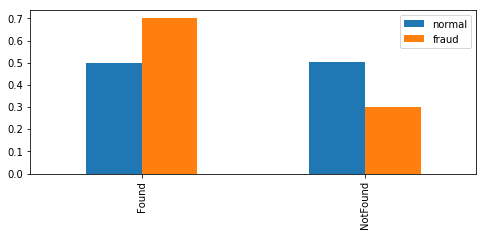

In [28]:
plotFraudBar('id_16')

C:\Users\Jose Gonzalez\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jose Gonzalez\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


KeyError: 'id_31_ua'

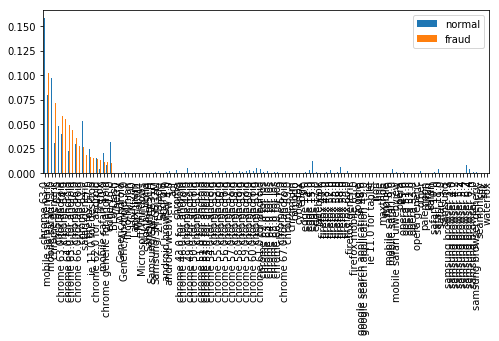

In [8]:
plotFraudBar('id_31', 20)

train_identity_0['_id_31_ua'] = train_identity_0['id_31'].apply(lambda x: x.split()[0] if x == x else 'unknown')
train_identity_1['_id_31_ua'] = train_identity_1['id_31'].apply(lambda x: x.split()[0] if x == x else 'unknown')
plotFraudBar('id_31_ua', 10)

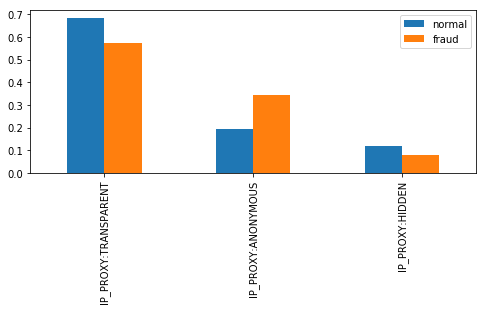

In [30]:
# by type of ip proxy, surprise surprise anonymous had highest % rate of fraud
plotFraudBar('id_23')

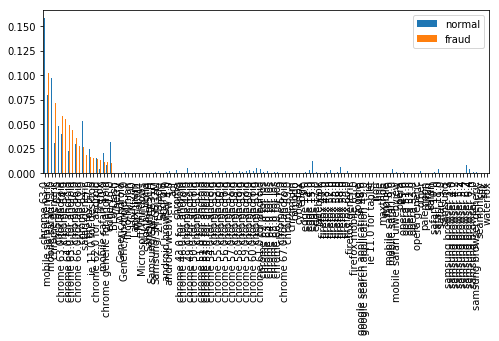

In [31]:
# needs work before it is readable
plotFraudBar('id_31', 20)

## Device Type

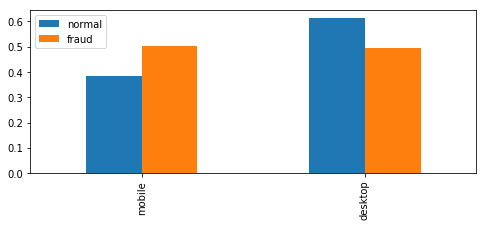

In [32]:
# device type
# find out how many NAs are in this 
plotFraudBar('DeviceType')

In [3]:
train_transaction_0 = train_transaction[train_transaction['isFraud'] == 0]
train_transaction_1 = train_transaction[train_transaction['isFraud'] == 1]
print(train_transaction_0.shape, train_transaction_1.shape)

(569877, 394) (20663, 394)


## Sampling for visuals

In [12]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
print(train.shape)
print(test.shape)

(590540, 435)
(506691, 434)


In [13]:
y_train = train['isFraud'].astype('uint8')
print('Train shape', train.shape)

Train shape (590540, 435)


In [14]:
X_train, X_test, y_train, y_test=train_test_split(train.drop('isFraud', axis=1), y_train, test_size=.2, random_state=1)

In [15]:
X = pd.concat([X_train, y_train], axis=1)

not_fraud = X[X.isFraud==0]
fraud = X[X.isFraud==1]

fraud_upsample = resample(fraud,
                         replace=True, 
                          n_samples = len(not_fraud), 
                          random_state=27)

upsample = pd.concat([not_fraud, fraud_upsample])

upsample.isFraud.value_counts()

1    455903
0    455903
Name: isFraud, dtype: int64

Text(0.5, 1.0, 'Oversampling minority class count')

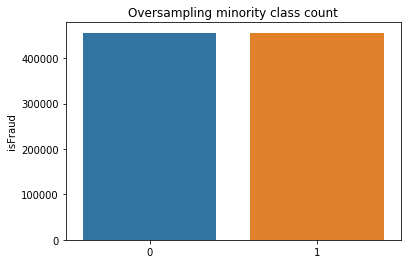

In [16]:
y = upsample.isFraud.value_counts()
sns.barplot(y=y, x=[0,1])
plt.title('Oversampling minority class')

## ROC curve graphic

In [28]:
# define function to create curve plot
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0,1], [0,1], color='blue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [29]:
# generate sample data
data_X, class_label = make_classification(n_samples=1000, n_classes=2, weights=[1,1], random_state=1)

In [30]:
# split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(data_X, class_label, test_size=0.3, random_state=1)

In [31]:
# fit model on train data
model = RandomForestClassifier()
model.fit(X_train, y_train)

C:\Users\Jose Gonzalez\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [33]:
# predict probabilites
probs = model.predict_proba(X_test)

In [34]:
probs = probs[:,1]

In [35]:
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)

AUC: 0.95


In [36]:
fpr, tpr, thresholds = roc_curve(y_test, probs)

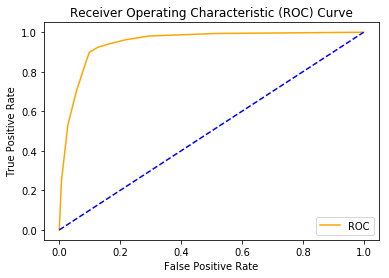

In [37]:
plot_roc_curve(fpr, tpr)

## SMOTE visual attempt

In [93]:
def plot_2d_space(X_train, y_train,X=X,y=y ,label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    fig,(ax1,ax2)=plt.subplots(1,2, figsize=(8,4))
   
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(
            X_train[y_train==l, 0],
            X_train[y_train==l, 1],
            c=c, label=l, marker=m
        )
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
   
    ax1.set_title(label)
    ax2.set_title('Original data')
    plt.legend(loc='upper right')
    plt.show()

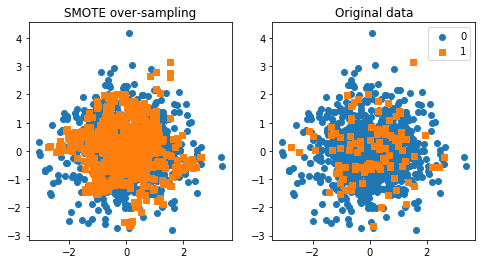

In [94]:
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm, X, y, 'SMOTE over-sampling')

## Function to create histograms of transaction fraud

In [43]:
# def plotTransactionFraudHist(col, bins=20):
#     with np.errstate(invalid='ignore'):
#         plt.figure(figsize=(8,3))
#         plt.hist([train_transaction_0[col], train_transaction_1[col]], bins=bins, density=True, color=['blue', 'red'])

In [35]:
train_transaction['TransactionDT'].min(), train_transaction['TransactionDT'].max()

(86400, 15811131)

In [36]:
test_transaction['TransactionDT'].min(), test_transaction['TransactionDT'].max()

(18403224, 34214345)

In [40]:
# def appendLagDT(df):
#     df = df.assign(_TransactionDT_lag = df['TransactionDT'] - df.groupby(['card1', 'card2', 'addr1'])['TransactionDT'].shift(1))

# train_transaction = appendLagDT(train_transaction)
# train_transaction_0 = train_transaction[train_transaction['isFraud'] == 0]
# train_transaction_1 = train_transaction[train_transaction['isFraud'] == 1]


## Attempt at preprocessing

In [9]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
print(train.shape)
print(test.shape)

(590540, 435)
(506691, 434)


In [13]:
train_transaction = pd.read_csv('data/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('data/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('data/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('data/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('data/sample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()
# del train_transaction, test_transaction, train_identity, test_identity

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1).copy()
X_test = test.copy()
# del train, test


X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))

(590540, 433)
(506691, 432)


In [14]:
clf = xgb.XGBClassifier(n_estimators=50, max_depth=9, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
                        missing=-999, random_state=2019, tree_method='gpu_hist')

In [15]:
%time clf.fit(X_train, y_train)

XGBoostError: [11:07:52] C:/Jenkins/workspace/xgboost-win64_release_0.90/src/tree/updater_gpu_hist.cu:1407: Exception in gpu_hist: [11:07:52] c:\jenkins\workspace\xgboost-win64_release_0.90\src\common\device_helpers.cuh:860: Check failed: device_ordinals.size() == 1 (0 vs. 1) : XGBoost must be compiled with NCCL to use more than one GPU.


## LGBM

In [5]:
n_fold = 5 
folds = TimeSeriesSplit(n_splits=n_fold).split(X)
folds = KFold(n_splits=5)

NameError: name 'TimeSeriesSplit' is not defined

In [6]:
def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', 
                               columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, 
                               splits=None, n_folds=3, averaging='usual', n_jobs=-1):
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test[columns]

In [7]:
params = {'num_leaves':256, 'min_child_samples': 79, 'objective': 'binary', 'max_depth': 13, 'learning_rate': 0.03,
         'boosting_type': 'gbdt', 'subsample_freq': 3, 'subsample': 0.9, 'bagging_seed': 11, 'metric': 'auc', 'verbosity': -1,
         'reg_alpha': 0.3, 'reg_lambda': 0.3, 'colsample_bytree': 0.9}

dict_result_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb',
                                            eval_metric='auc', plot_feature_importance=True, verbose=500,
                                            early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

NameError: name 'X' is not defined

In [ ]:
# X_train, X_val = X.iloc[train_index], X.iloc[val_index]
# y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [8]:
%%time

params = {'num_leaves': 500,
          'min_child_weight': 0.03,
          'feature_fraction': 0.35,
          'bagging_fraction': 0.35,
          'min_data_in_leaf': 100,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.025,
          "boosting_type": "gbdt",
          "bagging_seed": 10,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.2,
          'reg_lambda': 0.6,
          'random_state': 50,
          'device': 'gpu',
          'gpu_platform_id': 0,
          'gpu_device_id': 0
         }


dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=100, early_stopping_rounds=200)
    

prediction_LGB = model.predict(X_test)
prediction_val_LGB = model.predict(X_val)

NameError: name 'X_train' is not defined

### Feature Engineering

In [22]:
# Log TransactionAmt
train_transaction['TransactionAmt_Log'] = np.log(train_transaction['TransactionAmt'])
test_transaction['TransactionAmt_Log'] = np.log(test_transaction['TransactionAmt'])

In [23]:
print(train_transaction['TransactionAmt_Log'].head())
print(test_transaction['TransactionAmt_Log'].head())

TransactionID
2987000    4.226834
2987001    3.367296
2987002    4.077537
2987003    3.912023
2987004    3.912023
Name: TransactionAmt_Log, dtype: float64
TransactionID
3663549    3.464172
3663550    3.891820
3663551    5.141664
3663552    5.652314
3663553    4.218772
Name: TransactionAmt_Log, dtype: float64


In [7]:
# id_14 is time zone, should we create a feature out of this and try to find correlations or impute/encode it?
time_zone = train_identity['id_14']
time_zone.head()

0   -480.0
1   -300.0
2      NaN
3      NaN
4   -300.0
Name: id_14, dtype: float16

In [ ]:
# make visuals for isFraud rates/counts by each type of id_ and/or card_type, etc.?

## Feature importance and F-score

In [40]:
# # feature importance graph with F-score on bottom
# F1, F-score, or F-measure can be interpreted as a weighted average of the precision and recall best score at value 1,
# worst score at value 0, relative contribution of precision and recall is equal
import matplotlib.pyplot as plt
from matplotlib import pyplot
from xgboost import plot_importance

plot_importance(xgb, num_features=30, importance_type='gain')
plt.show()

In [41]:
from lightgbm import LGBMClassifier

plot_importance(lgb, num_features=30, importance_type='gain')
plt.show()